In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('precision', 5)

In [2]:
path = '/data/Dropbox/Data/Asylum_Courts/tbl_schedule'
raw_folder = '/data/Dropbox/Data/Asylum_Courts/raw'

In [3]:
cols = ["IDNSCHEDULE","IDNPROCEEDING","IDNCASE","OSC_DATE","GENERATION","SUB_GENERATION","REC_TYPE","ALIEN_ATTY_CODE","LANG","HEARING_LOC_CODE","BASE_CITY_CODE","IJ_CODE","INTERPRETER_CODE","INPUT_DATE","INPUT_TIME","UPDATE_DATE","UPDATE_TIME","ASSIGNMENT_PATH","CONTINUE_FLAG","CAL_TYPE","ADJ_DATE","ADJ_TIME_START","ADJ_TIME_STOP","ADJ_RSN","ADJ_MEDIUM","ADJ_MSG","ADJ_ELAP_DAYS","ID_1","LNGSESSNID","SCHEDULE_TYPE","NOTICE_CODE","DATBATCHMODIFIED","STRCREATEDBY","STRMODIFIEDBY","BLNCLOCKOVERRIDE","EOIRAttorneyID"]
cols = [x.lower() for x in cols]

In [4]:
sched_tbl = pd.read_csv(path + '/tbl_schedule_01.csv', header=None, names=cols, encoding='ISO-8859-1', low_memory=False, dtype={'adj_date':'str', 'adj_time_start':'str', 'adj_time_stop':'str'})

In [5]:
sched_tbl.count()

idnschedule         7710560
idnproceeding       7710542
idncase             7710560
osc_date            7707682
generation          7709369
sub_generation       592617
rec_type            7710530
alien_atty_code     4259127
lang                7288862
hearing_loc_code    7710558
base_city_code      7710558
ij_code             7709156
interpreter_code      10772
input_date          7710558
input_time          7710203
update_date         7710556
update_time         7710536
assignment_path      387076
continue_flag             0
cal_type            7706235
adj_date            7710560
adj_time_start      7710558
adj_time_stop       6728583
adj_rsn             6672863
adj_medium          7508811
adj_msg             1923835
adj_elap_days       2719424
id_1                1594869
lngsessnid          5686379
schedule_type       7710559
notice_code         5453180
datbatchmodified     292701
strcreatedby        7710205
strmodifiedby       7697821
blnclockoverride    7710560
eoirattorneyid      

In [6]:
sched_tbl2 = sched_tbl[['idnschedule','idnproceeding','idncase','osc_date','ij_code','cal_type', 'lang','hearing_loc_code', 'base_city_code', 'alien_atty_code', 'adj_date','adj_time_start','adj_time_stop','adj_rsn','schedule_type', 'notice_code','eoirattorneyid']]

In [7]:
sched_tbl2 = sched_tbl2.dropna(subset=['idnschedule', 'idnproceeding', 'idncase', 'adj_date'])
sched_tbl2.count()

idnschedule         7710542
idnproceeding       7710542
idncase             7710542
osc_date            7707664
ij_code             7709138
cal_type            7706217
lang                7288862
hearing_loc_code    7710540
base_city_code      7710540
alien_atty_code     4259121
adj_date            7710542
adj_time_start      7710540
adj_time_stop       6728571
adj_rsn             6672852
schedule_type       7710541
notice_code         5453180
eoirattorneyid      4157165
dtype: int64

## Creating attorney_present feature

In [8]:
sched_tbl2['alien_atty_code'] = sched_tbl2['alien_atty_code'].astype('str').str.strip().replace('', np.nan)

In [9]:
sched_tbl2.loc[sched_tbl2.alien_atty_code.notnull(), 'attorney_present'] = 'YES'
sched_tbl2.loc[sched_tbl2.alien_atty_code.isnull(), 'attorney_present'] = 'NO'

## Mapping and cleaning lang

In [10]:
lang_map = pd.read_excel('../tbl_language.xlsx')

In [11]:
lang_map.count()

lang            550
lang_hearing    550
dtype: int64

In [12]:
len(sched_tbl2.lang.unique())

508

In [13]:
sched_tbl2['lang'] = sched_tbl2['lang'].astype('str').str.strip()
lang_map['lang'] = lang_map['lang'].astype('str').str.strip()

In [14]:
sched_tbl2 = pd.merge(sched_tbl2, lang_map, on=['lang'], how='left')

In [15]:
sched_tbl2.count()

idnschedule         7710566
idnproceeding       7710566
idncase             7710566
osc_date            7707688
ij_code             7709162
cal_type            7706241
lang                7710566
hearing_loc_code    7710564
base_city_code      7710564
alien_atty_code     7332485
adj_date            7710566
adj_time_start      7710564
adj_time_stop       6728593
adj_rsn             6672876
schedule_type       7710565
notice_code         5453196
eoirattorneyid      4157188
attorney_present    7710566
lang_hearing        7287338
dtype: int64

In [16]:
# mark the ones that don't match as UNKNOWN
sched_tbl2['lang_hearing'] = sched_tbl2['lang_hearing'].fillna('UNKNOWN LANGUAGE')

## Mapping and cleaning hearing_loc_code

In [17]:
hearingloc_map = pd.read_csv(raw_folder + '/tblLookupHloc.csv', header=None)

In [18]:
hearingloc_map.head(5)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,2,AAP,ATLANTA AIRPORT,** INACTIVE HEARING LOCATION **,"CONCOURSE E., ROOM A",ATLANTA,GA,30320,9999999999,ATL,...,2,0,0,0,30,0,0,11,False,False
1,288,ABQ,REGIONAL CORRECTIONS CENTER,REGIONAL CORRECTIONS CENTER,415 ROMA NW,ALBUQUERQUE,NM,87102,5052426177,ELP,...,2,0,0,0,30,0,0,10,False,True
2,3,ADC,DHS-Litigation Unit/Oakdale,IMMIGRATION COURT,1900 East Whatley Road,OAKDALE,LA,71463,318335365,OAK,...,0,0,0,0,30,0,0,5,False,True
3,326,ADE,ADELANTO DETENTION FACILITY EAST,IMMIGRATION COURT,10400 RANCHO ROAD,ADELANTO,CA,923012237,2138942811,ADL,...,2,0,0,0,30,0,0,9,True,True
4,341,ADL,ADELANTO,IMMIGRATION COURT,"10250 RANCHO RD., SUITE 201A",ADELANTO,CA,92301,1111111111,ADL,...,2,0,0,0,30,0,0,9,False,False


In [19]:
hearingloc_map = hearingloc_map.rename(columns={1:'hearing_loc_code', 5:'hearing_city', 6:'hearing_state'})

In [20]:
sched_tbl2['hearing_loc_code'] = sched_tbl2['hearing_loc_code'].astype('str').str.strip()
hearingloc_map['hearing_loc_code'] = hearingloc_map['hearing_loc_code'].astype('str').str.strip()

In [21]:
hearingloc_map = hearingloc_map[['hearing_loc_code','hearing_city','hearing_state']]

In [22]:
sched_tbl2 = pd.merge(sched_tbl2, hearingloc_map, on=['hearing_loc_code'], how='left')

In [23]:
sched_tbl2['hearing_city'] = sched_tbl2['hearing_city'].fillna('UNKNOWN')
sched_tbl2['hearing_state'] = sched_tbl2['hearing_state'].fillna('UNKNOWN')

In [24]:
# delete some columns from dataframe
sched_tbl2 = sched_tbl2.drop(columns=['alien_atty_code','lang','hearing_loc_code'])

## Mapping and cleaning base_city_code

In [25]:
basecity_map = pd.read_csv(raw_folder + '/tblLookupBaseCity.csv', header=None)

In [26]:
basecity_map.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2,AGA,IMMIGRATION COURT ...,M,"108 HERNAN CORTEZ AVE., RM 126",HAGATNA,GU,96910,0.0,6714727528,...,NaN,NaN,NaN,NaN,2004-09-12 23:35:21.247000000,NaN,2007-01-13 11:58:28.187000000,AGA Conversion,True,False
1,3,ATL,OFFICE OF THE IMMIGRATION JUDGE,M,"180 SPRING ST., SW, SUITE 241",ATLANTA,GA,30303,0.0,4043310907,...,NaN,NaN,NaN,NaN,2004-09-12 23:35:21.247000000,NaN,2007-11-09 08:40:33,NongP,True,True
2,4,BAL,IMMIGRATION COURT ...,M,"31 HOPKINS PLAZA, ROOM 440",BALTIMORE,MD,21201,0.0,4109623092,...,NaN,NaN,NaN,NaN,2004-09-12 23:35:21.247000000,NaN,2006-07-01 10:18:49.623000000,BAL Conversion,True,True
3,5,BDC,IMMIGRATION COURT,NaN,"515 11TH ST., WEST SUITE 300",BRADENTON,FL,34205,1111.0,9417491044,...,NaN,NaN,NaN,NaN,2004-09-12 23:35:21.247000000,NaN,2007-03-19 14:20:24,fruehwad,False,True
4,6,BIA,BOARD OF IMMIGRATION APPEALS ...,NaN,5107 LEESBURG PIKE SUITE 1711,FALLS CHURCH,VA,22041,0.0,703305242,...,NaN,NaN,NaN,NaN,2004-09-12 23:35:21.247000000,NaN,NaN,NaN,True,False


In [27]:
basecity_map = basecity_map.rename(columns={1:'base_city_code', 5:'base_city', 6:'base_state'})

In [28]:
basecity_map = basecity_map[['base_city_code','base_city','base_state']]

In [29]:
basecity_map.head(5)

,base_city_code,base_city,base_state
0,AGA,HAGATNA,GU
1,ATL,ATLANTA,GA
2,BAL,BALTIMORE,MD
3,BDC,BRADENTON,FL
4,BIA,FALLS CHURCH,VA


In [30]:
sched_tbl2['base_city_code'] = sched_tbl2['base_city_code'].astype('str').str.strip()
basecity_map['base_city_code'] = basecity_map['base_city_code'].astype('str').str.strip()

In [31]:
sched_tbl2 = pd.merge(sched_tbl2, basecity_map, on=['base_city_code'], how='left')

In [32]:
sched_tbl2['base_city'] = sched_tbl2['base_city'].fillna('UNKNOWN')
sched_tbl2['base_state'] = sched_tbl2['base_state'].fillna('UNKNOWN')

## Mapping and cleaning sched_type

In [33]:
schedtype_map = pd.read_csv(raw_folder + '/tbllookupSchedule_Type.csv', header=None)

In [34]:
schedtype_map.head(5)

,0,1,2,3,4,5,6,7,8,9
0,1,**,Non-Work,2002-11-21 12:46:14.360000000,EOIRHDQ\eckertk,NaN,NaN,N,True,True
1,29,--,UNKNOWN,2007-10-18 08:26:28.770000000,admin,2007-10-18 08:26:28.770000000,admin,-,False,True
2,23,AA,Administrative,NaN,NaN,NaN,NaN,N,True,True
3,21,AD,Admin Leave,2002-11-21 12:46:14.360000000,EOIRHDQ\eckertk,NaN,NaN,S,True,True
4,25,AN,Annual Leave,NaN,NaN,NaN,NaN,S,True,True


In [35]:
schedtype_map = schedtype_map.rename(columns={1:'schedule_type', 2:'sched_type'})
schedtype_map = schedtype_map[['schedule_type', 'sched_type']]

In [36]:
sched_tbl2['schedule_type'] = sched_tbl2['schedule_type'].astype('str').str.strip()
schedtype_map['schedule_type'] = schedtype_map['schedule_type'].astype('str').str.strip()

In [37]:
sched_tbl2 = pd.merge(sched_tbl2, schedtype_map, on=['schedule_type'], how='left')

In [38]:
sched_tbl2 = sched_tbl2.drop(columns=['schedule_type', 'base_city_code'])

## Mapping and cleaning notice_code

In [39]:
notice_map = pd.read_csv(raw_folder + '/eoir/tblLookupNOTICE.csv', header=None)

In [40]:
notice_map.head(5)

,0,1,2,3,4,5,6,7,8
0,1,#Q,RELIEF FROM EXCLUSION ABANDONED - DEPORT,NaN,NaN,NaN,NaN,True,N
1,2,$Q,RELIEF FROM DEPORT ABANDONED - DEPORT,NaN,NaN,NaN,NaN,True,N
2,3,&F,ORDER ON MOTION TO REOPEN BOND PROCEEDINGS,NaN,NaN,2005-10-08 11:09:08.310000000,ECP-CASE-57,False,N
3,4,*0,REJ. PROTECTIVE ORDER FOR LACK OF CERTIFICATE SEV,NaN,NaN,2005-12-13 13:48:01,Forsmany,True,N
4,5,*1,GRANTING A MOTION FOR A PROTECTIVE ORDER,NaN,NaN,2005-10-08 11:09:21.420000000,ECP-CASE-57,True,N


In [41]:
notice_map = notice_map.rename(columns={1:'notice_code', 2:'notice_desc'})
notice_map = notice_map[['notice_code', 'notice_desc']]

In [42]:
sched_tbl2['notice_code'] = sched_tbl2['notice_code'].astype('str').str.strip()
notice_map['notice_code'] = notice_map['notice_code'].astype('str').str.strip()

In [43]:
sched_tbl2 = pd.merge(sched_tbl2, notice_map, on=['notice_code'], how='left')

In [44]:
sched_tbl2['notice_desc'] = sched_tbl2['notice_desc'].fillna('UNKNOWN')

In [45]:
sched_tbl2 = sched_tbl2.drop(columns=['notice_code', 'eoirattorneyid', 'cal_type'], axis=1)

## Mapping and cleaning ij_code

In [46]:
ij_map = pd.read_csv(raw_folder + '/ijcodemap.csv')

In [47]:
ij_map.head(5)

,EOIR ID,EOIR Data,TRAC Id
0,AA,Anthony Atenaide,185
1,AAT,A. Ashley Tabaddor,103
2,AAV,Alan A. Vomacka,216
3,ADP,"Anthony D. Petrone, Jr.",230
4,AED,Alison E Daw,88


In [48]:
ij_map = ij_map.rename(columns={'EOIR ID':'ij_code', 'TRAC Id':'trac_id'})
ij_map = ij_map[['ij_code', 'trac_id']]

In [49]:
sched_tbl2['ij_code'] = sched_tbl2['ij_code'].astype('str').str.strip()
ij_map['ij_code'] = ij_map['ij_code'].astype('str').str.strip()

In [50]:
ij_map = ij_map.drop_duplicates('ij_code')

In [51]:
sched_tbl2 = pd.merge(sched_tbl2, ij_map, on=['ij_code'], how='left')

In [52]:
# not mapped to any trac_id
sched_tbl2[sched_tbl2.trac_id.isnull()]['ij_code'].unique()

array(['CLR', 'LRM', 'VIJ', 'VIS', 'GZM', 'CEA', 'RJD', 'ACB', 'DK',
       'RLE', 'AMC', 'JSS', 'HGW', 'HIC', 'MEP', 'CAL', 'VJ1', 'GGD',
       'JM', 'JMS', 'XXX', 'SS', 'FJL', 'SJM', 'AMD', 'LDC', 'DLK', 'MJB',
       'IJ5', 'BQM', 'MFS', 'WEW', 'MAS', 'WD', 'VJ5', 'nan', 'CLE',
       'IJ6', 'VJ2', 'VJ3', 'cep', 'ZZP', 'cka', 'IJD', 'CRY', 'DRK',
       'OLD', 'MAM', 'IWE', 'BUF', 'RTG', 'JNB', 'SBM', 'WRR', 'MCK',
       'SCB', 'S', 'VJ9', 'VHJ', 'CCS', 'RSC', 'FF', 'JRS', 'OJN', 'IHK',
       'CM', 'RS0', 'CHI', 'JJJ', 'HOR', 'IJ2', 'WBT', 'AIM', 'EPE', 'WF',
       'HIM', 'IF', 'MMS', 'AS', 'AAS', 'WBG', 'SG', 'JPR', 'DET', 'ipf',
       'VID', 'IJC', 'GWS', 'VJ', '801', 'AAA', 'jlr', 'AJM', 'PAD',
       'QBV', 'HU1', 'HU2', 'HU3', 'COR', 'HU', 'HUB', 'jdl', 'FC', 'CR',
       'SVJ', 'VJ4', 'RP1', 'ao', 'TFJ', 'CAH', 'AMP', 'JCO', 'JTH',
       'ATL', 'EHM', 'TRE'], dtype=object)

In [53]:
sched_tbl2.count()

idnschedule         7710566
idnproceeding       7710566
idncase             7710566
osc_date            7707688
ij_code             7710566
adj_date            7710566
adj_time_start      7710564
adj_time_stop       6728593
adj_rsn             6672876
attorney_present    7710566
lang_hearing        7710566
hearing_city        7710566
hearing_state       7710566
base_city           7710566
base_state          7710566
sched_type          7710566
notice_desc         7710566
trac_id             7597831
dtype: int64

In [54]:
sched_tbl2['trac_id'] = sched_tbl2['trac_id'].fillna('UNKNOWN')

## Cleaning adj_date, adj_time_start, adj_time_stop

In [55]:
#sched_tbl2['adj_date'] = sched_tbl2['adj_date'].astype('str')
sched_tbl2['adj_date'] = pd.to_datetime(sched_tbl2['adj_date'])

In [56]:
sched_tbl2['adj_time_start'] = sched_tbl2['adj_time_start'].str.zfill(4)
sched_tbl2['adj_time_stop'] = sched_tbl2['adj_time_stop'].str.zfill(4)

In [57]:
#sched_tbl2['adj_time_start'] = sched_tbl2['adj_time_start'].str[:2] + ':' + sched_tbl2['adj_time_start'].str[2:]
#sched_tbl2['adj_time_stop'] = sched_tbl2['adj_time_stop'].str[:2] + ':' +sched_tbl2['adj_time_stop'].str[2:]

In [58]:
sched_tbl2['adj_time_start'] = pd.to_datetime(sched_tbl2['adj_time_start'], format='%H%M', errors='coerce')
sched_tbl2['adj_time_stop'] = pd.to_datetime(sched_tbl2['adj_time_stop'], format='%H%M', errors='coerce')
#sched_tbl2['adj_time_start'] = pd.to_timedelta(sched_tbl2['adj_time_start'], errors='coerce')

In [59]:
sched_tbl2['adj_time_start'].head(5)

0   1900-01-01 13:00:00
1   1900-01-01 08:30:00
2   1900-01-01 13:00:00
3   1900-01-01 09:00:00
4   1900-01-01 13:00:00
Name: adj_time_start, dtype: datetime64[ns]

In [60]:
# extract adj_date year-month-day portion
d = sched_tbl2['adj_date'].dt.strftime('%Y-%m-%d')

#pd.to_datetime(sched_tbl2['adj_time_start'].dt.strftime('{} %H:%M:%S'.format(sched_tbl2['adj_date'])))
#a.strftime('{} %H:%M:%S'.format(b.strftime('%Y-%m-%d')))
d.head(5)

0    1996-11-27
1    1991-05-21
2    1997-04-02
3    1996-04-16
4    2003-01-08
Name: adj_date, dtype: object

In [61]:
sched_tbl2.loc[sched_tbl2.adj_time_start.dt.hour == 0, 'adj_time_start'] = pd.NaT
sched_tbl2.loc[sched_tbl2.adj_time_stop.dt.hour == 0, 'adj_time_stop'] = pd.NaT

In [62]:
sched_tbl2.loc[sched_tbl2.adj_time_start.dt.hour < 6, 'adj_time_start'] += pd.to_timedelta(12, unit='h')
sched_tbl2.loc[sched_tbl2.adj_time_stop.dt.hour < 6, 'adj_time_stop'] += pd.to_timedelta(5, unit='h')

In [63]:
t_start = sched_tbl2['adj_time_start'].dt.strftime('%H:%M:%S')
t_stop = sched_tbl2['adj_time_stop'].dt.strftime('%H:%M:%S')
#sched_tbl2['adj_time_start'] = sched_tbl2['adj_time_start'].transform(lambda x: x.strftime('{} %H:%M:%S'.format(d)))

In [64]:
sched_tbl2['adj_time_start2'] = pd.to_datetime(d + " " + t_start, errors='coerce')
sched_tbl2['adj_time_stop2'] = pd.to_datetime(d + " " + t_stop, errors='coerce')

In [65]:
sched_tbl2.head(10)

,idnschedule,idnproceeding,idncase,osc_date,ij_code,adj_date,adj_time_start,adj_time_stop,adj_rsn,attorney_present,lang_hearing,hearing_city,hearing_state,base_city,base_state,sched_type,notice_desc,trac_id,adj_time_start2,adj_time_stop2
0,17035561,961394.0,2706979,1995-06-30 00:00:00,LIS,1996-11-27,1900-01-01 13:00:00,1900-01-01 14:30:00,01,YES,CAPE VERDIAN,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,19,1996-11-27 13:00:00,1996-11-27 14:30:00
1,17035562,961398.0,2706991,1991-01-18 00:00:00,LIS,1991-05-21,1900-01-01 08:30:00,1900-01-01 09:00:00,14,NO,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,19,1991-05-21 08:30:00,1991-05-21 09:00:00
2,17035563,961402.0,2707014,1995-05-17 00:00:00,BWD,1997-04-02,1900-01-01 13:00:00,1900-01-01 16:30:00,NaN,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,226,1997-04-02 13:00:00,1997-04-02 16:30:00
3,17035564,961405.0,2707014,1995-05-17 00:00:00,PS,1996-04-16,1900-01-01 09:00:00,1900-01-01 10:30:00,NaN,YES,UNKNOWN LANGUAGE,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,20,1996-04-16 09:00:00,1996-04-16 10:30:00
4,17035565,961406.0,2707020,1996-03-12 00:00:00,ECK,2003-01-08,1900-01-01 13:00:00,1900-01-01 16:00:00,04,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,18,2003-01-08 13:00:00,2003-01-08 16:00:00
5,17035566,961407.0,2707020,1996-03-12 00:00:00,ECK,2001-03-15,1900-01-01 09:00:00,1900-01-01 09:30:00,01,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,18,2001-03-15 09:00:00,2001-03-15 09:30:00
6,17035567,961409.0,2707025,1995-07-25 00:00:00,BWD,1996-10-29,1900-01-01 13:00:00,1900-01-01 14:30:00,03,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,226,1996-10-29 13:00:00,1996-10-29 14:30:00
7,17035568,961410.0,2707031,1990-08-23 00:00:00,KAB,1991-09-24,1900-01-01 13:00:00,1900-01-01 16:00:00,NaN,YES,PORTUGUESE,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,186,1991-09-24 13:00:00,1991-09-24 16:00:00
8,17035569,961412.0,2707037,1994-12-20 00:00:00,TMR,1995-08-09,1900-01-01 09:00:00,1900-01-01 10:30:00,NaN,NO,UNKNOWN LANGUAGE,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,228,1995-08-09 09:00:00,1995-08-09 10:30:00
9,17035570,961413.0,2707042,1994-10-03 00:00:00,LIS,1995-02-01,1900-01-01 13:00:00,1900-01-01 16:30:00,01,NO,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,19,1995-02-01 13:00:00,1995-02-01 16:30:00


In [66]:
sched_tbl2['durationHearing'] = sched_tbl2['adj_time_stop2'] - sched_tbl2['adj_time_start2']

In [67]:
sched_tbl2[sched_tbl2.adj_time_stop2 < sched_tbl2.adj_time_start2].count()

idnschedule         2555
idnproceeding       2555
idncase             2555
osc_date            2555
ij_code             2555
adj_date            2555
adj_time_start      2555
adj_time_stop       2555
adj_rsn             1944
attorney_present    2555
lang_hearing        2555
hearing_city        2555
hearing_state       2555
base_city           2555
base_state          2555
sched_type          2555
notice_desc         2555
trac_id             2555
adj_time_start2     2555
adj_time_stop2      2555
durationHearing     2555
dtype: int64

In [68]:
# converting the unit to minutes
sched_tbl2['durationHearing'] = sched_tbl2['durationHearing'].astype('timedelta64[m]')

In [69]:
sched_tbl2 = sched_tbl2[sched_tbl2.durationHearing >= 0]

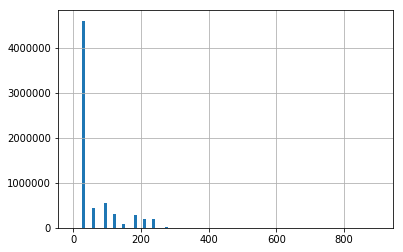

In [70]:
sched_tbl2['durationHearing'].hist(bins=100)
plt.show()

In [71]:
sched_tbl2 = sched_tbl2.drop(columns=['adj_time_start', 'adj_time_stop', 'ij_code'], axis=1)

In [72]:
sched_tbl2.count()

idnschedule         6725795
idnproceeding       6725795
idncase             6725795
osc_date            6725303
adj_date            6725795
adj_rsn             6020723
attorney_present    6725795
lang_hearing        6725795
hearing_city        6725795
hearing_state       6725795
base_city           6725795
base_state          6725795
sched_type          6725795
notice_desc         6725795
trac_id             6725795
adj_time_start2     6725795
adj_time_stop2      6725795
durationHearing     6725795
dtype: int64

In [73]:
sched_tbl2.head(10)

,idnschedule,idnproceeding,idncase,osc_date,adj_date,adj_rsn,attorney_present,lang_hearing,hearing_city,hearing_state,base_city,base_state,sched_type,notice_desc,trac_id,adj_time_start2,adj_time_stop2,durationHearing
0,17035561,961394.0,2706979,1995-06-30 00:00:00,1996-11-27,01,YES,CAPE VERDIAN,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,19,1996-11-27 13:00:00,1996-11-27 14:30:00,90.0
1,17035562,961398.0,2706991,1991-01-18 00:00:00,1991-05-21,14,NO,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,19,1991-05-21 08:30:00,1991-05-21 09:00:00,30.0
2,17035563,961402.0,2707014,1995-05-17 00:00:00,1997-04-02,NaN,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,226,1997-04-02 13:00:00,1997-04-02 16:30:00,210.0
3,17035564,961405.0,2707014,1995-05-17 00:00:00,1996-04-16,NaN,YES,UNKNOWN LANGUAGE,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,20,1996-04-16 09:00:00,1996-04-16 10:30:00,90.0
4,17035565,961406.0,2707020,1996-03-12 00:00:00,2003-01-08,04,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,18,2003-01-08 13:00:00,2003-01-08 16:00:00,180.0
5,17035566,961407.0,2707020,1996-03-12 00:00:00,2001-03-15,01,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,18,2001-03-15 09:00:00,2001-03-15 09:30:00,30.0
6,17035567,961409.0,2707025,1995-07-25 00:00:00,1996-10-29,03,YES,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,226,1996-10-29 13:00:00,1996-10-29 14:30:00,90.0
7,17035568,961410.0,2707031,1990-08-23 00:00:00,1991-09-24,NaN,YES,PORTUGUESE,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,186,1991-09-24 13:00:00,1991-09-24 16:00:00,180.0
8,17035569,961412.0,2707037,1994-12-20 00:00:00,1995-08-09,NaN,NO,UNKNOWN LANGUAGE,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,228,1995-08-09 09:00:00,1995-08-09 10:30:00,90.0
9,17035570,961413.0,2707042,1994-10-03 00:00:00,1995-02-01,01,NO,ENGLISH,BOSTON,MA,BOSTON,MA,UNKNOWN,NO ADDRESS MTN TO REOPEN ORDER OF THE IJ - SNA,19,1995-02-01 13:00:00,1995-02-01 16:30:00,210.0


## Mapping and cleaning adj_rsn

In [74]:
adjrsn_map = pd.read_excel(raw_folder+'/dbo_tblAdjournmentcodes.xlsx')

In [75]:
adjrsn_map = adjrsn_map.rename(columns={'strcode':'adj_rsn', 'strDesciption':'adj_rsn_desc'})
adjrsn_map = adjrsn_map[['adj_rsn', 'adj_rsn_desc']]

In [76]:
adjrsn_map.head(10)

,adj_rsn,adj_rsn_desc
0,01,ALIEN TO SEEK REPRESENTATION
1,02,PREPARATION--ALIEN/ATTORNEY/REPRESENTATIVE
2,03,PREPARATION--DHS
3,04,DHS OR DHS ADMIN FILE UNAVAILABLE FOR HEARING
4,05,ALIEN TO FILE FOR ASYLUM
5,06,ALIEN TO FILE OTHER APPLICATION
6,07,ALIEN/DHS APPLICATION PROCESS
7,08,STATE DEPARTMENT RESPONSE NOT IN FILE
8,09,ALIEN IN DHS/CORR. CUSTODY NOT PRESENTED FOR HRG.
9,10,NOTICE SENT/SERVED INCORRECTLY


In [77]:
sched_tbl2['adj_rsn'] = sched_tbl2['adj_rsn'].astype('str').str.strip()
adjrsn_map['adj_rsn'] = adjrsn_map['adj_rsn'].astype('str').str.strip()

In [78]:
sched_tbl2.count()

idnschedule         6725795
idnproceeding       6725795
idncase             6725795
osc_date            6725303
adj_date            6725795
adj_rsn             6725795
attorney_present    6725795
lang_hearing        6725795
hearing_city        6725795
hearing_state       6725795
base_city           6725795
base_state          6725795
sched_type          6725795
notice_desc         6725795
trac_id             6725795
adj_time_start2     6725795
adj_time_stop2      6725795
durationHearing     6725795
dtype: int64

In [79]:
sched_tbl2 = pd.merge(sched_tbl2, adjrsn_map, on=['adj_rsn'], how='left')

In [80]:
# mark the ones that don't match as UNKNOWN
sched_tbl2['adj_rsn_desc'] = sched_tbl2['adj_rsn_desc'].fillna('UNKNOWN')

In [81]:
sched_tbl2.count()

idnschedule         6725795
idnproceeding       6725795
idncase             6725795
osc_date            6725303
adj_date            6725795
adj_rsn             6725795
attorney_present    6725795
lang_hearing        6725795
hearing_city        6725795
hearing_state       6725795
base_city           6725795
base_state          6725795
sched_type          6725795
notice_desc         6725795
trac_id             6725795
adj_time_start2     6725795
adj_time_stop2      6725795
durationHearing     6725795
adj_rsn_desc        6725795
dtype: int64

## Mapping cal_type

In [82]:
#caltype_map = pd.read_csv(raw_folder+'/eoir/tbllookupCal_Type.csv')

In [83]:
#caltype_map

In [84]:
#sched_tbl2['cal_type'].unique()

## Ouputting cleaned version

In [85]:
sched_tbl2.to_csv('../detailed_schedule.csv', index=False)